In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({
    'savefig.dpi': 300, 
    "figure.dpi": 300,
    "font.family": "Arial",
    "font.size": 6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "lines.linewidth": 0.8,
})

cm = 1/2.54  # centimeters in inches

Load Data

In [4]:
import load_plot_data

### modify load_data function in load_plot_data.py to add or remove certain sources
pdf = load_plot_data.load_data()

Load LPT data

In [5]:
lptlist = ["ASKAP J1935+2148", "GPM J1839-10", "GLEAM-X J1627", "ILT J1101+5521", "ASKAP J1832-0911"]

ldfs = []
for lpt in lptlist:
    _df = pd.read_csv(f"""./lpt/{lpt.replace(" ", "_")}.csv""")
    _df["source"] = lpt
    ldfs.append(_df)

ldf = pd.concat(ldfs).reset_index(drop=True)

lptconfig = {
    "ASKAP J1935+2148": dict(marker="^", color="tab:pink", s=25),
    "GLEAM-X J1627": dict(marker="o", color="tab:orange", s=25),
    "GPM J1839-10": dict(marker="s", color="tab:olive", s=25),
    "ILT J1101+5521": dict(marker="p", color="tab:purple", s=25),
    "GCRT J1745-3009": dict(marker="d", color="tab:red", s=25),
    "ASKAP J1832-0911": dict(marker="x", color="tab:cyan", s=25),
}

Load Plot Marker Configurations

In [6]:
plotconfig = pd.read_csv("./plotconfig.csv")

def find_label_color(label):
    lrow = plotconfig[plotconfig["label"] == label]
    if len(lrow) == 0: return "k"
    return lrow.iloc[0]["color"]

def format_text_argument(row):
    text = row["text"].replace("\\n", "\n")
    return dict(x=row["x"], y=row["y"], s=text, color=row["color"])

textplot = pd.read_csv("./plottext.csv", comment='!')#escapechar="\\")


Make plot

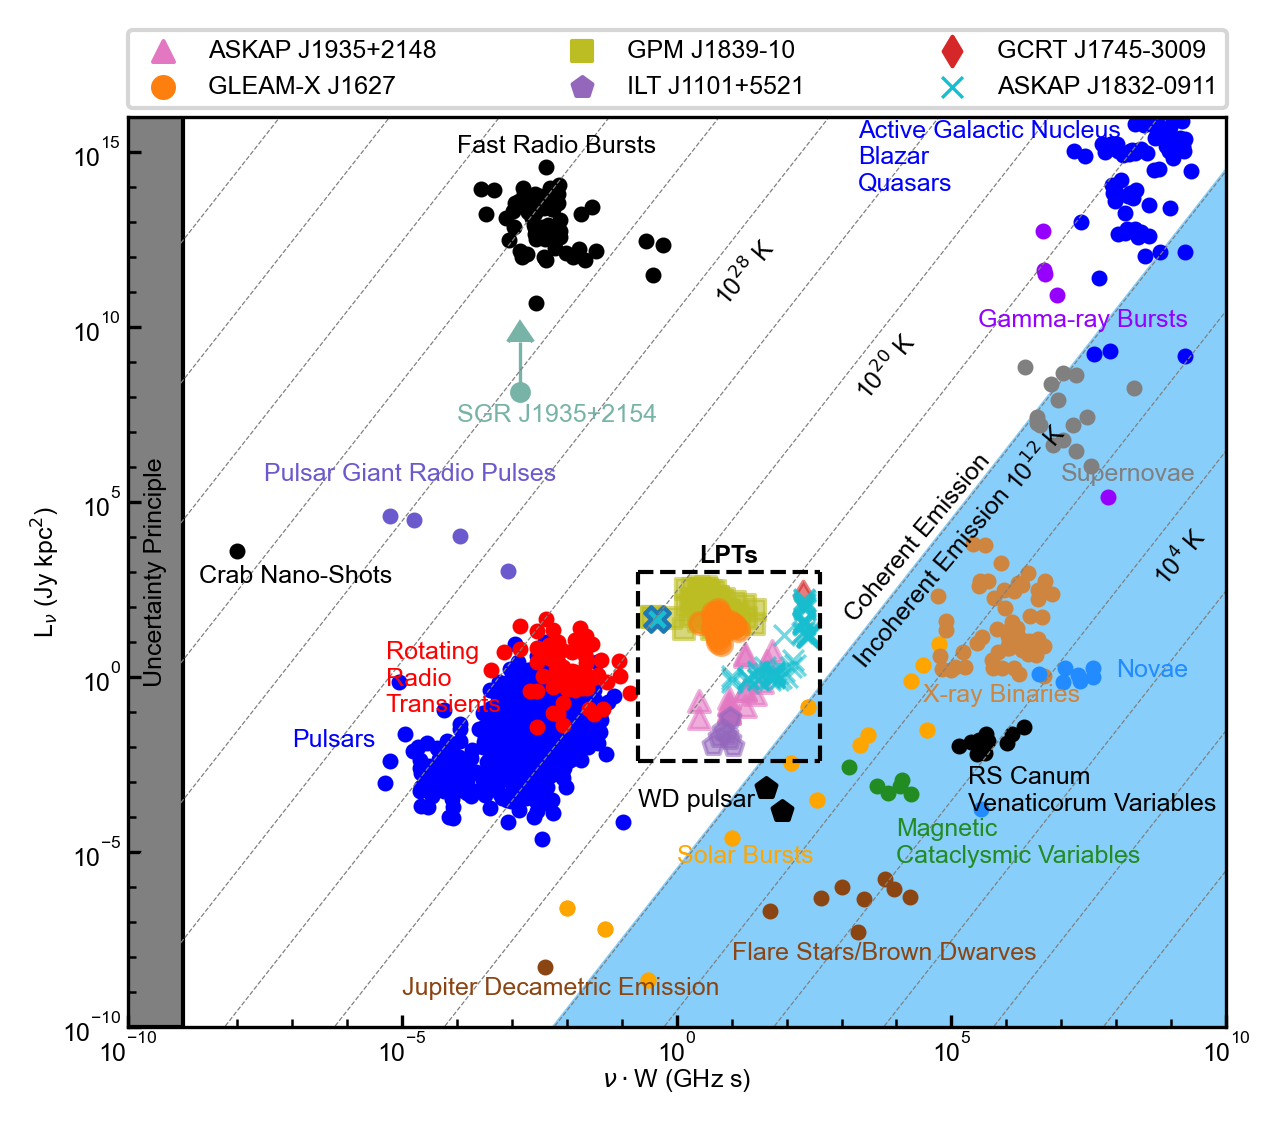

In [10]:
fig = plt.figure(figsize=(12*cm, 10*cm))
ax = fig.add_subplot(1, 1, 1)

labels = pdf["label"].unique()
for label in labels:

    sdf = pdf[pdf["label"] == label]
    if label == "lpt":
        pass
        # ax.scatter(sdf["xdata"], sdf["ydata"], s=75, color="purple", marker="*",)
    elif label == "GCRT":
        ax.scatter(sdf["xdata"], sdf["ydata"], s=25, color="tab:red", marker="d", alpha=0.6)
    elif label == "sgr1935":
        color = find_label_color(label)
        ax.errorbar(sdf["xdata"], sdf["ydata"], yerr=25*sdf["ydata"], lolims=True, color=color, marker="o", markersize=4)
    elif label == "lugia":
        # color = "#e0490d"
        ax.scatter(sdf["xdata"], sdf["ydata"], marker="x", color="tab:cyan", zorder=-1, alpha=0.6, s=25)
    else:
        color = find_label_color(label)
        ax.scatter(sdf["xdata"], sdf["ydata"], s=8, color=color, marker="o")

for lpt in lptlist:
    sdf = ldf[ldf["source"] == lpt]
    ax.scatter(sdf["x"], sdf["y"], alpha=0.6, **lptconfig[lpt])

for i, row in textplot.iterrows():
    kwargs = format_text_argument(row)
    ax.text(**kwargs)

### two white dwarfs...
ax.scatter(84, 1.46e-4, color="k", marker="p", s=25) # AR Sco
ax.scatter(41.34, 6.7e-4, color="k", marker="p", s=25) # J1912
ax.text(x=2e-1, y=2e-4, color="k", s="WD pulsar")

#### plot J1832...
ax.scatter(0.444, 44.18, color="tab:cyan", marker="X", s=35, edgecolor="tab:blue")

### adding uncertainty principle region
ax.axvspan(xmin=1e-11,xmax=1e-9, color="gray", ec="k")
ax.text(x=2e-10, y=1e3, s="Uncertainty Principle", va="center", rotation=90)

### adding TB
TBs = np.logspace(-8, 48, 15)
xx = np.logspace(-10, 10, 10)
for TB in TBs:
    # yy = (2*constants.k_B*TB*units.Kelvin*(xx * units.GHz * units.second) ** 2).to("Jy kpc^2").value
    yy = TB * 2.761*1.05025e-18 * xx**2
    ax.plot(xx, yy, ls="--", color="gray", lw=0.3)

### plot brighness temperature text...
ax.text(x=4e8,y=4e2,s=r"10$^4$ K", rotation=50.)
ax.text(x=8e5,y=2e5,s=r"10$^1$$^2$ K", rotation=50.)
ax.text(x=1.5e3,y=8e7,s=r"10$^2$$^0$ K", rotation=50.)
ax.text(x=4,y=4e10,s=r"10$^2$$^8$ K", rotation=50.)

### plot 10^12 K line
ax.fill_between(xx, 1e12 * 2.761*1.05025e-18 * xx**2, color="#87CEFA", zorder=-1)
ax.text(x=1e3,y=40,s="Coherent Emission", rotation=50.)
ax.text(x=1.5e3,y=2e0,s="Incoherent Emission", rotation=50.)

ax.set_yscale("log")
ax.set_xscale("log")

ax.xaxis.set_ticks(np.logspace(-10, 10, 5))
ax.xaxis.set_ticks(np.logspace(-10, 10, 21), minor=True, labels=[])
ax.yaxis.set_ticks(np.logspace(-10, 20, 7))
ax.yaxis.set_ticks(np.logspace(-10, 20, 31), minor=True, labels=[])

### add labels
for lpt in lptconfig:
    param = lptconfig[lpt]
    ax.scatter([], [], label=lpt, **param)
ax.legend(loc=(0., 1.01), ncol=3, frameon = 1, columnspacing=4.85)

### add LPT region
xmin = 2e-1
xmax = 4e2
ymin = 4e-3
ymax= 1e3
linewidth=1
linestyle="--"
ax.plot([xmin, xmax],[ymin, ymin], c='k', lw=linewidth, ls=linestyle)
ax.plot([xmin, xmax],[ymax, ymax], c='k', lw=linewidth, ls=linestyle)
ax.plot([xmin, xmin],[ymin, ymax], c='k', lw=linewidth, ls=linestyle)
ax.plot([xmax, xmax],[ymin, ymax], c='k', lw=linewidth, ls=linestyle)

ax.text(8.95, 1.3e3, "LPTs", va="bottom", ha="center", weight="bold")


ax.set_xlim(1e-10, 1e10)
ax.set_ylim(1e-10, 1e16)

ax.tick_params(axis="x", pad=1.5)
ax.tick_params(axis="y", pad=1.5)
ax.set_ylabel(r"L$_\nu$ (Jy kpc$^2$)", labelpad=0.)
ax.set_xlabel(r"$\nu\cdot$W (GHz s)", labelpad=0.)

fig.savefig("lpt_radio_transient_phase_space.pdf", bbox_inches="tight", dpi=300)